In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from optimization import *

In [2]:
def sample(d):
    return torch.concat((torch.rand(d), torch.ones(1)))

In [3]:
agent_attempts = 2
agent_iters = 200
dm_attempts = 6
dm_iters = 2000
temperature = 0.02

In [4]:
m = 2
d = 2
u = torch.tensor([0.15, 0.1])
W = torch.tensor([[1., 1/np.sqrt(5)], [0., 2/np.sqrt(5)], [0.2, 0.0]], dtype=torch.float32)
phi_opt = torch.tensor([[1., 0., 0.2], [1/np.sqrt(5), 2/np.sqrt(5), 0.]], dtype=torch.float32)
Xs = []
X_hats = []
xWs = []
phi = torch.rand((m, d + 1))
x = sample(d)
x_hat = gragent(x, phi, u, attempts=agent_attempts, iters=agent_iters, temp=temperature)
Xs.append(x)
X_hats.append(x_hat)
dataset = torch.stack(Xs)
dataset_hat = torch.stack(X_hats)
cum_dm_reward = dm_reward(dataset @ W, dataset_hat, phi, temp=temperature)
xW = gr_xW(cum_dm_reward.item(), x_hat, phi, temp=temperature, attempts=5, iters=1_000)
opt_cum_dm_reward = dm_reward(dataset @ W, dataset_hat, phi_opt, temp=temperature)
rand_cum_dm_reward = dm_reward(dataset @ W, dataset_hat, torch.rand((m, d + 1)), temp=temperature)
xWs.append(xW)
pred_xWs = torch.stack(xWs)

C:\Users\Alex\Desktop\academics\strat-bandits\strategic-bandits\optimization.py:93: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2318.)
  return softmax( phi @ x.T , temp=temp)


In [79]:
phi = gr_phi(dataset_hat, pred_xWs, u, temp=temperature, attempts=dm_attempts, iters=dm_iters, prev_phi=phi) # dataset @ W
x = sample(d)
x_hat = gragent(x, phi, u, attempts=agent_attempts, iters=agent_iters, temp=temperature)
Xs.append(x)
X_hats.append(x_hat)
dataset = torch.stack(Xs)
dataset_hat = torch.stack(X_hats)

new_dm_reward = dm_reward(dataset @ W, dataset_hat, phi, temp=temperature)
cum_dm_reward += new_dm_reward
xW = gr_xW(new_dm_reward.item(), x_hat, phi, temp=temperature, attempts=5, iters=1_000)
xWs.append(xW)
pred_xWs = torch.stack(xWs)

opt_new_dm_reward = dm_reward(dataset @ W, dataset, phi_opt, temp=temperature)
opt_cum_dm_reward += opt_new_dm_reward

rand_new_dm_reward = dm_reward(dataset @ W, dataset_hat, torch.rand((m, d + 1)), temp=temperature)
rand_cum_dm_reward += rand_new_dm_reward

lbls = [a[0] > a[1] for a in classify(x=dataset, phi=phi_opt, temp=temperature).T]
preds = [a[0] > a[1] for a in classify(x=dataset_hat, phi=phi, temp=temperature).T]
n = len(preds)
print('Random:   ', rand_cum_dm_reward.item() / n, rand_new_dm_reward.item())
print('Predicted:', cum_dm_reward.item() / n, new_dm_reward.item())
print('Optimal:  ', opt_cum_dm_reward.item() / n, opt_new_dm_reward.item())

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1328.98it/s]


Random:    0.7115113185002253 0.7969726920127869
Predicted: 0.7708889154287485 0.8663068413734436
Optimal:   0.8683026387141302 0.8953933119773865


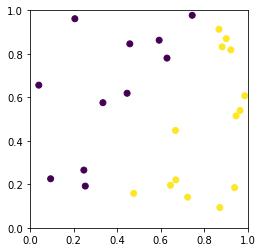

In [80]:
plt.gca().set_aspect('equal')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(dataset_hat[:,0], dataset_hat[:,1], c=preds)

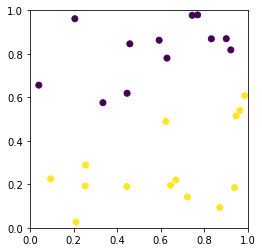

In [81]:
plt.gca().set_aspect('equal')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(dataset[:,0], dataset[:,1], c=lbls)

In [82]:
xWs, dataset @ W

([tensor([0.5660, 0.5968]),
  tensor([0.2822, 0.5415]),
  tensor([0.8680, 0.5155]),
  tensor([0.6200, 0.7289]),
  tensor([0.5777, 0.7554]),
  tensor([0.7386, 0.0548]),
  tensor([0.7864, 0.9579]),
  tensor([0.3811, 0.7748]),
  tensor([0.7623, 0.2101]),
  tensor([0.8287, 0.8251]),
  tensor([0.8024, 0.4571]),
  tensor([0.5852, 0.8803]),
  tensor([-0.0120,  0.8002]),
  tensor([0.2748, 0.7038]),
  tensor([0.8191, 0.3681]),
  tensor([0.8402, 0.4590]),
  tensor([0.8449, 0.6641]),
  tensor([0.0950, 0.8505]),
  tensor([0.8668, 0.6186]),
  tensor([0.5979, 0.8474]),
  tensor([0.8834, 0.8363]),
  tensor([0.8646, 0.3566]),
  tensor([0.9986, 0.8688]),
  tensor([0.7832, 0.4436]),
  tensor([0.4421, 0.8744]),
  tensor([0.9310, 0.8663])],
 tensor([[1.1406, 0.5860],
         [0.8703, 0.4970],
         [0.8457, 0.4636],
         [0.4553, 0.3717],
         [0.4538, 0.2851],
         [0.9234, 0.4503],
         [1.0727, 0.4733],
         [0.4060, 0.9521],
         [1.1650, 0.9142],
         [0.4113, 0.1182],